In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import ta
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import TimeSeriesSplit,train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from pykalman import KalmanFilter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
currency_pairs = ['EURUSD','GBPUSD','USDJPY','AUDUSD','NZDUSD','AUDCAD','USDCAD']
#currency_pairs = ['EURUSD','USDJPY','AUDCAD']
best_accuracies = {}

In [3]:
def SMA_diff(df, col, n, m):

    df[f"SMA_d_{n}"] = ta.trend.SMAIndicator(df[col], int(n)).sma_indicator()
    df[f"SMA_d_{m}"] = ta.trend.SMAIndicator(df[col], int(m)).sma_indicator()

    df[f"SMA_diff"] = df[f"SMA_d_{n}"] - df[f"SMA_d_{m}"]
    return df


def RSI_diff(df, col, n, m):

    df[f"RSI_{n}"] = ta.momentum.RSIIndicator(df[col], int(n)).rsi()
    df[f"RSI_{m}"] = ta.momentum.RSIIndicator(df[col], int(m)).rsi()

    df[f"RSI_diff"] = df[f"RSI_{n}"] - df[f"RSI_{m}"]

    return df

def SMA(df, col, n):
    
    df[f'SMA_{n}'] = df[col].rolling(window=n).mean()
    
    return df

#EMA
def EMA(df, col, n):
    
    df[f'EMA_{n}'] = df[col].ewm(span=n, adjust=False).mean()
    
    return df

#RSI
def RSI(df, col, n):
    
    rsi_series = ta.momentum.RSIIndicator(df[col], int(n)).rsi()  
    df[f"RSI_{n}"] = rsi_series  
    
    return df

def RSI_lowess(df, col, n, frac=0.01):
    # RSI
    rsi_period = int(n)
    df['RSI'] = ta.momentum.RSIIndicator(df[col], window=rsi_period).rsi()

    df['RSI'].fillna(0, inplace=True)

    numerical_index = df.index.map(pd.Timestamp.timestamp)

    smoothed_rsi = lowess(df['RSI'], numerical_index, frac=frac, it=3)

    # RSI_Lowess
    df['RSI_lowess'] = smoothed_rsi[:, 1]

    return df

#SMOOTH_RSI
def smooth_RSI(df, col, n, ma_type='SMA', ma_period=10):
    rsi_series = ta.momentum.RSIIndicator(df[col], int(n)).rsi()  
    df[f"RSI_{n}"] = rsi_series  
    if ma_type == 'SMA':
        df[f"RSI_{n}_{ma_type}_{ma_period}"] = df[f"RSI_{n}"].rolling(window=ma_period).mean()
    elif ma_type == 'EMA':
        df[f"RSI_{n}_{ma_type}_{ma_period}"] = df[f"RSI_{n}"].ewm(span=ma_period, adjust=False).mean()
        
    return df
#STO_RSI
def STO_RSI(df, col, n):

    StoRsi = ta.momentum.StochRSIIndicator(df[col], int(n))
    
    df[f"STO_RSI_{n}"] = StoRsi.stochrsi() * 100
    df[f"STO_RSI_D_{n}"] = StoRsi.stochrsi_d() * 100
    df[f"STO_RSI_K_{n}"] = StoRsi.stochrsi_k() * 100
    
    return df
#ATR
def ATR(df, n):
    
    df[f"ATR_{n}"] = ta.volatility.AverageTrueRange(df["high"], df["low"], df["close"], n).average_true_range()
    
    return df

#SMOOTH ATR
def smooth_ATR(df, n, ma_type='SMA', ma_period=10):
    
    df[f"ATR_{n}"] = ta.volatility.AverageTrueRange(df["high"], df["low"], df["close"], n).average_true_range()
    if ma_type == 'SMA':
        df[f"ATR_{n}_{ma_type}_{ma_period}"] = df[f"ATR_{n}"].rolling(window=ma_period).mean()
    elif ma_type == 'EMA':
        df[f"ATR_{n}_{ma_type}_{ma_period}"] = df[f"ATR_{n}"].ewm(span=ma_period, adjust=False).mean()
        
    return df
#MACD
def MACD(df, col, n_fast=12, n_slow=26, n_signal=9):

    #MACD
    macd_indicator = ta.trend.MACD(df[col],window_slow=n_slow,window_fast=n_fast,window_sign=n_signal)

    #MACD Columns
    df[f'MACD_{n_fast}_{n_slow}'] = macd_indicator.macd()
    df[f'MACD_signal_{n_signal}'] = macd_indicator.macd_signal()
    df[f'MACD_histogram_{n_fast}_{n_slow}_{n_signal}'] = macd_indicator.macd_diff()

    return df

#SMOOTH_MACD
def smooth_MACD(df, col, n_fast=12, n_slow=26, n_signal=9, ma_type='SMA', ma_period=10):
    
    macd_indicator = ta.trend.MACD(df[col], window_slow=n_slow, window_fast=n_fast, window_sign=n_signal)
    df[f'MACD_{n_fast}_{n_slow}'] = macd_indicator.macd()
    df[f'MACD_signal_{n_signal}'] = macd_indicator.macd_signal()
    df[f'MACD_histogram_{n_fast}_{n_slow}_{n_signal}'] = macd_indicator.macd_diff()
    
    # Suavizar el histograma MACD
    if ma_type == 'SMA':
        df[f'MACD_histogram_{n_fast}_{n_slow}_{n_signal}_{ma_type}_{ma_period}'] = df[f'MACD_histogram_{n_fast}_{n_slow}_{n_signal}'].rolling(window=ma_period).mean()
    elif ma_type == 'EMA':
        df[f'MACD_histogram_{n_fast}_{n_slow}_{n_signal}_{ma_type}_{ma_period}'] = df[f'MACD_histogram_{n_fast}_{n_slow}_{n_signal}'].ewm(span=ma_period, adjust=False).mean()
    
    return df

#STK
def STK(df, close_col, low_col, high_col, n):

    stoch = ta.momentum.StochasticOscillator(high=df[high_col], low=df[low_col], close=df[close_col], window=n, smooth_window=10)
    
    df[f'STK_{n}'] = stoch.stoch()

    return df

#STD
def rolling_std(df, col, n):
    
    df[f'std_{n}'] = df[col].rolling(window=n).std()
    
    return df

#RSI_LOWESS


#CMMA
def CMMA(df, close_col, high_col, low_col, lookback, atr_length):

    n = len(df)
    output = np.zeros(n)
    front_bad = max(lookback, atr_length)

    for i in range(front_bad, n):
        # ATR
        tr = np.maximum(
            df[high_col].iloc[i - atr_length + 1:i + 1] - df[low_col].iloc[i - atr_length + 1:i + 1],
            np.abs(df[high_col].iloc[i - atr_length + 1:i + 1] - df[close_col].iloc[i - atr_length:i].shift(1)),
            np.abs(df[low_col].iloc[i - atr_length + 1:i + 1] - df[close_col].iloc[i - atr_length:i].shift(1))
        )
        atr = np.mean(tr)

        # LOG AVERAGE
        log_avg = np.mean(np.log(df[close_col].iloc[i - lookback:i]))

        if atr > 0:
            denom = atr * np.sqrt(lookback + 1)
            z_score = (np.log(df[close_col].iloc[i]) - log_avg) / denom
            output[i] = 100.0 * norm.cdf(z_score) - 50.0
        else:
            output[i] = 0.0

    df[f"CMMA_{lookback}"] = output

    return df

def kalman_filter(df, close_col, window=None):

    valores = df[close_col].values

    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=0.01)


    state_means, _ = kf.filter(valores)

    df[f"kalman_{close_col}"] = state_means

    if window:
        df[f"kalman_{close_col}_{window}"] = df[f"kalman_{close_col}"].rolling(window=window).mean()

    return df

#TREND
def calculate_trend(df, close_col, high_col, low_col, lookback, atr_length, trend_type):
    n = len(df)
    output = np.zeros(n)
    front_bad = max(lookback, atr_length)

    # Legendre simulation
    if trend_type == 'linear':
        coefs = np.linspace(-1, 1, lookback)
        col_name = 'linear_trend'
    elif trend_type == 'quadratic':
        coefs = np.linspace(-1, 1, lookback)**2
        col_name = 'quad_trend'
    elif trend_type == 'cubic':
        coefs = np.linspace(-1, 1, lookback)**3
        col_name = 'cubic_trend'
    else:
        raise ValueError("Tren no valid 'linear', 'quadratic' o 'cubic'.")

    for icase in range(front_bad, n):
        # ATR (Average True Range)
        tr = np.maximum(
            df[high_col].iloc[icase - atr_length + 1:icase + 1] - df[low_col].iloc[icase - atr_length + 1:icase + 1],
            np.abs(df[high_col].iloc[icase - atr_length + 1:icase + 1] - df[close_col].iloc[icase - atr_length:icase].shift(1)),
            np.abs(df[low_col].iloc[icase - atr_length + 1:icase + 1] - df[close_col].iloc[icase - atr_length:icase].shift(1))
        )
        atr = np.mean(tr)

        # Log promedian
        log_prices = np.log(df[close_col].iloc[icase - lookback:icase])
        dot_prod = np.dot(log_prices, coefs)
        log_avg = np.mean(log_prices)

        if atr > 0:
            # Z-score based ATR
            denom = atr * np.sqrt(lookback + 1)
            z_score = (dot_prod - log_avg) / denom
            output[icase] = 100.0 * norm.cdf(z_score) - 50.0
        else:
            output[icase] = 0.0

    df[f"{col_name}_{lookback}"] = output
    return df

#ENTROPY
class Entropy:
    def __init__(self, wordlen):

        if wordlen < 1:
            self.ok = False
            self.bins = None
            return
        
        self.wordlen = wordlen
        self.nbins = 2 ** wordlen  # n bins ^wordlenght
        self.bins = np.zeros(self.nbins, dtype=int)  # bins initialilzed
        self.ok = True

    def entropy(self, nx, wordlen, x):

        if wordlen < 1 or nx <= wordlen:
            return 0.0

        # Bins
        self.bins.fill(0)
        
        # Count Bins
        for i in range(wordlen, nx):
            k = 1 if x[i - 1] > x[i] else 0
            for j in range(1, wordlen):
                k *= 2
                if x[i - j - 1] > x[i - j]:
                    k += 1
            self.bins[k] += 1

        # Entropy
        ent = 0.0
        total_bins = nx - wordlen
        for i in range(self.nbins):
            p = self.bins[i] / total_bins
            if p > 0.0:
                ent -= p * np.log(p)

        # Norm entropy
        return ent / np.log(self.nbins)


def entropy_filter(df, close_col, wordlen, window=None):

    valores = df[close_col].values
    
    # Init Entropy
    entropy_instance = Entropy(wordlen)
    
    # Entropy each point
    entropia = np.zeros(len(valores))
    for i in range(len(valores)):
        if i < wordlen:
            entropia[i] = 0  # First value no entropy
        else:
            entropia[i] = entropy_instance.entropy(i + 1, wordlen, valores[:i + 1][::-1])
    
    # Add column
    df[f"entropy_{close_col}"] = entropia
    
    # Promedian jic
    if window:
        df[f"entropy_{close_col}_{window}"] = df[f"entropy_{close_col}"].rolling(window=window).mean()
    
    return df
    
#PRICE INTENSITY
def price_intensity(df, col='close', n=10):
    # Validar la columna
    if col not in df.columns:
        raise ValueError(f"La columna '{col}' no existe en el DataFrame.")

    close_col = df[col].values
    open_col = df['open'].values
    high_col = df['high'].values
    low_col = df['low'].values
    n_to_smooth = int(n + 0.5)

    if n_to_smooth < 1:
        n_to_smooth = 1

    n_data = len(df)
    output = np.zeros(n_data)
    
    # La primera barra no tiene barra previa
    denom = high_col[0] - low_col[0]
    if denom < 1.e-60:
        denom = 1.e-60
    output[0] = (close_col[0] - open_col[0]) / denom

    # Calcular valores crudos
    for icase in range(1, n_data):
        denom = high_col[icase] - low_col[icase]
        if high_col[icase] - close_col[icase - 1] > denom:
            denom = high_col[icase] - close_col[icase - 1]
        if close_col[icase - 1] - low_col[icase] > denom:
            denom = close_col[icase - 1] - low_col[icase]
        if denom < 1.e-60:
            denom = 1.e-60
        output[icase] = (close_col[icase] - open_col[icase]) / denom

    # Suavizar si se solicita
    if n_to_smooth > 1:
        alpha = 2.0 / (n_to_smooth + 1.0)
        smoothed = output[0]
        for icase in range(1, n_data):
            smoothed = alpha * output[icase] + (1.0 - alpha) * smoothed
            output[icase] = smoothed

    # Transformación final y compresión leve
    for icase in range(n_data):
        output[icase] = 100.0 * norm.cdf(0.8 * np.sqrt(n_to_smooth) * output[icase]) - 50.0

    # Agregar la columna al DataFrame
    df[f"price_intensity_{n_to_smooth}"] = output
    return df

# PERCENTAGE PRICE OSCILLATOR (PPO)
def PPO(df, close_col, short_length, long_length, n_to_smooth=1):
    # Convert lengths to integers
    short_length = int(short_length + 0.5)
    long_length = int(long_length + 0.5)
    n_to_smooth = int(n_to_smooth + 0.5)
    
    # Initialize variables
    n = len(df)
    front_bad = long_length + n_to_smooth
    if front_bad > n:
        front_bad = n
    back_bad = 0
    
    long_alpha = 2.0 / (long_length + 1.0)
    short_alpha = 2.0 / (short_length + 1.0)
    
    long_sum = short_sum = df[close_col].iloc[0]
    output = np.zeros(n)
    output[0] = 0.0  # Poorly defined at first case
    
    # Compute PPO
    for icase in range(1, n):
        long_sum = long_alpha * df[close_col].iloc[icase] + (1.0 - long_alpha) * long_sum
        short_sum = short_alpha * df[close_col].iloc[icase] + (1.0 - short_alpha) * short_sum
        output[icase] = 100.0 * (short_sum - long_sum) / (long_sum + 1.e-15)  # Official PPO
        
        # Optional normalization (comment out if not needed)
        output[icase] = 100.0 * norm.cdf(0.2 * output[icase]) - 50.0
    
    # Smooth if requested
    if n_to_smooth > 1:
        alpha = 2.0 / (n_to_smooth + 1.0)
        smoothed = output[0]
        for icase in range(1, n):
            smoothed = alpha * output[icase] + (1.0 - alpha) * smoothed
            output[icase] -= smoothed
    
    # Store PPO result in DataFrame
    df[f"PPO_{short_length}_{long_length}"] = output
    
    return df


def create_features(df):
    
    df = SMA_diff(df, "close", 30, 120)
    df = RSI(df, "close", 14)
    df = RSI_lowess(df, "close",14, frac=0.01)
    df = kalman_filter(df, 'close', window=10)


    return df

def future_returns_label(df, n):
    n = int(n)
    df_copy = df.copy()

    # Crea la columna fut_ret para calcular la señal
    df_copy["fut_ret"] = (df_copy["close"].shift(-n) - df_copy["open"]) / df_copy["open"]

    # Rellena NaN en fut_ret con 0 (puedes cambiar esto según tus necesidades)
    df_copy.dropna(inplace=True)

    # Crear la columna de etiquetas
    df_copy[f"label_{n}"] = 0
    df_copy.loc[df_copy['fut_ret'] > 0, f"label_{n}"] = 1

    return df_copy

In [4]:
list_X = [
    'SMA_diff',
          #'RSI_14',
          #'kalman_close_10',
          'RSI_lowess']

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Fitting 5 folds for each of 540 candidates, totalling 2700 fits


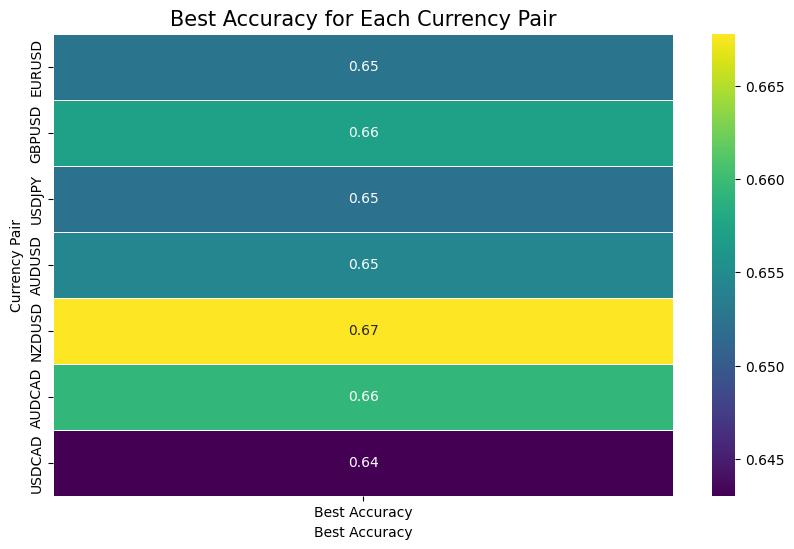

In [5]:
use_scaling = False
use_pca     = False

for pair in currency_pairs:
    file_path = f"C:/Users/jlaho/Desktop/Quantreo/Quant/Data/FixTimeBars/{pair}_H4_MT5_READY.csv"
    
    # Read data
    df = pd.read_csv(file_path, index_col="time", parse_dates=True)
    df_feat = create_features(df)
    n = 10
    df_labeled = future_returns_label(df_feat, n)
    
    # Data for model
    X = df_labeled[list_X]
    col_y = f"label_{n}" 
    y = df_labeled[col_y]

    # Scaling data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  # Scale

    if use_scaling:
        scaler = StandardScaler()
        X_processed = scaler.fit_transform(X)  # Scale data
    else:
        X_processed = X.values  # Use raw data without scaling

    # Apply PCA if use_pca is set to True
    if use_pca:
        varianz_desired = 2
        pca = PCA(n_components=varianz_desired)
        X_processed = pca.fit_transform(X_processed)  # Apply PCA

    # Split data into training and testing sets
    train_size = int(len(df_labeled) * 1.0)
    X_train = X_processed[:train_size, :]  
    y_train = y.iloc[:train_size]     
    X_test = X_processed[train_size:, :]    
    y_test = y.iloc[train_size:] 

    # Entrenar el modelo
    model = RandomForestClassifier(random_state=42)
    param_grid = {
        'bootstrap': [True,False],
        'criterion': ["gini","entropy"],
        'max_depth': [2,4,6,8,10],
        'min_samples_leaf': [2,3,4],
        'min_samples_split': [2,3,4],
        'n_estimators': [10,100,200]
    }

    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=tscv, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train) 
        
    # Best CV scores
    best_valid_score = grid_search.best_score_
    best_accuracies[pair] = best_valid_score

# To df
accuracy_df = pd.DataFrame(list(best_accuracies.items()), columns=['Currency Pair', 'Best Accuracy'])

# Heatmap
heatmap_data = accuracy_df.set_index('Currency Pair')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='viridis', linewidths=.5)
plt.title("Best Accuracy for Each Currency Pair", size=15)
plt.ylabel("Currency Pair")
plt.xlabel("Best Accuracy")
plt.show()

In [6]:
model = RandomForestClassifier(
    random_state=42,
    bootstrap=True,
    criterion="gini",
    max_depth=12,
    min_samples_leaf=6,
    min_samples_split=2,
    n_estimators=100
)

# Train the model directly without cross-validation
model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = model.predict(X_train)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Accuracy on training set: {train_accuracy:.4f}")

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on test set: {test_accuracy:.4f}")

Accuracy on training set: 0.7813


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by RandomForestClassifier.